<a href="https://colab.research.google.com/github/deysohom99/Separation-of-arteriovenous-trees-from-fundus-images/blob/master/Separation-of-arteriovenous-trees-from-fundus-images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
%%capture

!wget http://webeye.ophth.uiowa.edu/abramoff/AV_groundTruth.zip

!unzip AV_groundTruth.zip 

import os
os.remove('AV_groundTruth.zip')

In [0]:
train_images_path = 'AV_groundTruth/training/images'
train_av_path = 'AV_groundTruth/training/av'

test_images_path = 'AV_groundTruth/test/images'
test_av_path = 'AV_groundTruth/test/av'

train_images_files = sorted([os.path.join(train_images_path, i) for i in os.listdir(train_images_path)])
train_av_files = sorted([os.path.join(train_av_path, i) for i in os.listdir(train_av_path)])

test_images_files = sorted([os.path.join(test_images_path, i) for i in os.listdir(test_images_path)])
test_av_files = sorted([os.path.join(test_av_path, i) for i in os.listdir(test_av_path)])

In [0]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from albumentations import Compose, OneOf, CLAHE, Flip, Rotate, RGBShift, RandomContrast, RandomGamma, RandomBrightness
from sklearn.metrics import classification_report

In [0]:
class Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=5, augmentation=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.augmentation = augmentation

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)

  aug = Compose(
    [ 
      CLAHE(always_apply=True, p=1.0),
      OneOf([
              Flip(),
              Rotate()
            ], p=0.8),
      OneOf([
              RGBShift(),
            ], p=0.5),
      OneOf([
              RandomContrast(),
              RandomGamma(),
              RandomBrightness()
            ], p=0.5)
    ])

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_x])
      batch_y = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_y])

      if self.augmentation is True:
        aug = [self.aug(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])

      return batch_x/255.0, batch_y/255.0
  

In [0]:
train_generator = Generator(train_images_files, train_av_files)
valid_generator = Generator(test_images_files, test_av_files)

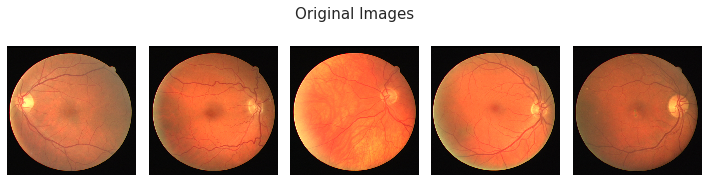

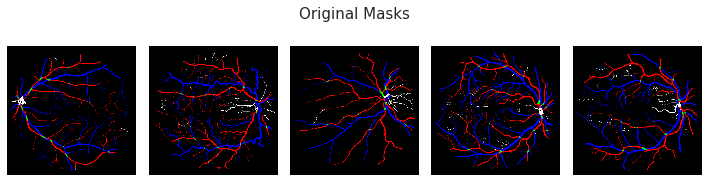

In [40]:
for i, j in train_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(10,3))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(10,3))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [0]:
def train_generator():
  return Generator(train_images_files, train_av_files, augmentation=True).__iter__()
def valid_generator():
  return Generator(test_images_files, test_av_files, augmentation=False).__iter__()


ds_train = tf.data.Dataset.from_generator(
    train_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([5,512,512,3], [5,512,512,3])
).repeat()

ds_valid = tf.data.Dataset.from_generator(
    valid_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([5,512,512,3], [5,512,512,3])
).repeat()


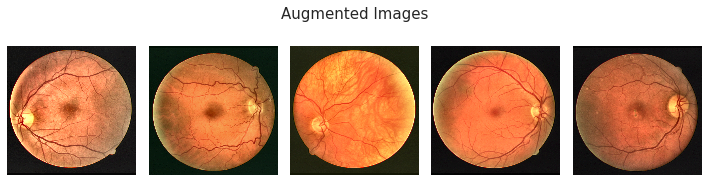

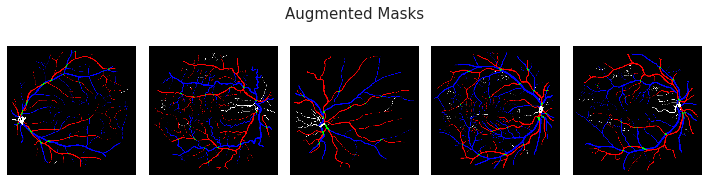

In [43]:
for i, j in ds_train:
    break

fig, axes = plt.subplots(1, 5, figsize=(10,3))
fig.suptitle('Augmented Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(10,3))
fig.suptitle('Augmented Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [0]:
def UNet():

  inputs = Input((512, 512, 3))

  c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
  c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D((2, 2)) (c4)

  c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1])
  c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [0]:
K.clear_session()
model = UNet()

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
earlystopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=10, 
    verbose=1, 
    restore_best_weights=True)

reducelr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=5, 
    verbose=1,  
    min_delta=0.0001 )

callbacks = [earlystopping, reducelr]

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(
    ds_train, 
    steps_per_epoch=40,
    epochs=200,
    validation_data = ds_valid,    
    validation_steps = 4,
    callbacks=callbacks
    )

Train for 40 steps, validate for 4 steps
Epoch 1/200
40/40 [==============================] - 35s 883ms/step - loss: 0.1945 - accuracy: 0.9296 - val_loss: 0.1136 - val_accuracy: 0.9577
Epoch 2/200
40/40 [==============================] - 23s 564ms/step - loss: 0.1150 - accuracy: 0.9547 - val_loss: 0.1148 - val_accuracy: 0.9577
Epoch 3/200
40/40 [==============================] - 23s 567ms/step - loss: 0.1077 - accuracy: 0.9546 - val_loss: 0.1107 - val_accuracy: 0.9577
Epoch 4/200
40/40 [==============================] - 23s 566ms/step - loss: 0.0993 - accuracy: 0.9559 - val_loss: 0.1142 - val_accuracy: 0.9577
Epoch 5/200
40/40 [==============================] - 23s 568ms/step - loss: 0.0968 - accuracy: 0.9562 - val_loss: 0.0977 - val_accuracy: 0.9579
Epoch 6/200
40/40 [==============================] - 23s 564ms/step - loss: 0.0891 - accuracy: 0.9563 - val_loss: 0.1018 - val_accuracy: 0.9579
Epoch 7/200
40/40 [==============================] - 23s 568ms/step - loss: 0.0836 - accuracy: 

In [0]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [0]:
test_generator = Generator(test_images_files, test_av_files, 20)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)

y_true = (y_test>0.5).flatten()
y_pred = (y_pred>0.5).flatten()

In [0]:
report = classification_report(y_true, y_pred, output_dict=True)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Precision score: {0:.2f}\n".format(Precision))
print("Recall score: {0:.2f}\n".format(Recall))
print("F1-Score: {0:.2f}\n".format(F1_score))
print("Sensitivity: {0:.2f}\n".format(Sensitivity))
print("Specificity: {0:.2f}\n".format(Specificity))
print("IOU: {0:.2f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(y_true, y_pred))